In [ ]:
# =========================
# CME with AR model — same behavior, refactored
# =========================
# autoreload ipynb
%load_ext autoreload
%autoreload 2

import math, torch, numpy as np
import torch.nn.functional as F
from torch import nn
from torch.func import vmap
from torchrl.modules.tensordict_module.rnn import LSTMCell
from VAN4CME.CRN.GeneExpression import GeneExpressionCRN, GeneExpressionCRNWithFeedback
from VAN4CME.CRN.Represilator import RepressilatorCRN
from VAN4CME.GSVAN import GSVAN
from VAN4CME.Training.Trainer import train_minimal, train_minimal_ppo

# ---------------- utils --------------------------------------------

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- lattice & lookup ---------------------------------

# ------- usage example ---------------------------------------------
# crn = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2, DEVICE=DEVICE, M_MAX=50, P_MAX=50)
crn = GeneExpressionCRNWithFeedback(k_r=5, k_p=1, g_r=0.2, g_p=0.5, feedback=.2, DEVICE=DEVICE, M_MAX=50, P_MAX=50)
# Represilator parameters: 
# k2 = 0.3
# k3 = 2
# k4 = 0.07
# k6 = 0.3
# k7 = 2
# k8 = 0.07
# k10 = 0.3
# k11 = 2
# k12 = 0.07
# phi1 = 0.5
# phi2 = 0.00005
# crn = RepressilatorCRN(phi1=phi1,
#         phi2=phi2,
#         k2=k2, k3=k3, k4=k4,
#         k6=k6, k7=k7, k8=k8,
#         k10=k10, k11=k11, k12=k12, device=DEVICE, max_count=[20,200,20,200,20,200])
net = GSVAN(crn, hidden=256, tau=5.0, DEVICE=DEVICE, use_species_operator=False)
TF = 5.
try:
    train_minimal(crn, net, steps=100000, K=2**13, lr=1e-3, t_max=TF,
                mix_alpha=None, unbiased_is=True, w_clip=None, report=100, DEVICE=DEVICE, beta_time=1.0, use_w_time=False, gamma=2.0, selected_losses=["residual", "ic", "entropy"], weights=[1.0, 2.0, 0.005])
    # train_minimal_ppo(crn, net, steps=100000, K=2**13, lr=1e-3, t_max=TF,
    #             mix_alpha=None, unbiased_is=True, w_clip=None, report=100, DEVICE=DEVICE, beta_time=1.0, use_w_time=False, gamma=1.0, selected_losses=["residual", "ic", "entropy"], weights=[1.0, 2.0, 0.05],
    #             ppo_clip=0.2, use_ppo_clipping=True, kl_coef=0.0, update_old_every=5)
    # train_minimal_wasserstein(
    #     crn, net, steps=10000, K=4096*4, lr=1e-4, lr_critic=1e-4,
    #     t_max=1.5, report=10, mix_alpha=None, unbiased_is=True,
    #     w_clip=None, DEVICE=DEVICE, beta_time=2., use_w_time=True,
    #     n_critic=1, gp_lambda=0.0,   # set gp_lambda>0 if you prefer GP over spectral norm
    #     gamma_unused=2.0,            # kept for API symmetry; not used now
    #     normalize_for_phi=None,      # dict with {'mean':..., 'std':...} per species if you want
    # )
except KeyboardInterrupt:
    print("Training interrupted.")

step     1 | loss 1.596e+01 | res 2.178e-01 | ic 7.772e+00 | rmse 2.334e-03 | |dpdt| 2.391e-05 | |Ap| 1.298e-03 | entropy 3.930e+00 | mixα 1.00 | ESS ~ 8192/8192 (1.00)
step   100 | loss 4.809e+00 | res 1.891e+00 | ic 1.362e+00 | rmse 9.706e-02 | |dpdt| 7.976e-03 | |Ap| 3.529e-03 | entropy 3.893e+00 | mixα 1.00 | ESS ~ 8192/8192 (1.00)
step   200 | loss 3.354e+00 | res 6.145e-01 | ic 1.275e+00 | rmse 8.985e-02 | |dpdt| 9.396e-03 | |Ap| 4.771e-03 | entropy 3.789e+00 | mixα 1.00 | ESS ~ 8192/8192 (1.00)
step   300 | loss 2.010e+00 | res 5.998e-01 | ic 6.145e-01 | rmse 1.309e-01 | |dpdt| 3.571e-02 | |Ap| 2.307e-02 | entropy 3.630e+00 | mixα 1.00 | ESS ~ 8192/8192 (1.00)
step   400 | loss 2.389e+00 | res 1.130e+00 | ic 5.376e-01 | rmse 1.322e-01 | |dpdt| 3.879e-02 | |Ap| 2.927e-02 | entropy 3.674e+00 | mixα 1.00 | ESS ~ 8192/8192 (1.00)
step   500 | loss 1.631e+00 | res 8.591e-01 | ic 3.003e-01 | rmse 1.687e-01 | |dpdt| 6.536e-02 | |Ap| 5.211e-02 | entropy 3.431e+00 | mixα 1.00 | ESS ~ 819

In [2]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_marginals_model(
    crn, net, t,
    K_per_species=20_000,     # total MC budget per species
    chunk_size=2_048,         # streamed eval size (controls VRAM)
    cols=3, figsize=(14, 8),
    title=None,
    last_species_range=(0, 20)  # override range [lo, hi] for the LAST species
):
    """
    Plot model-consistent marginals p_theta(x_s | t) for each species by averaging
    the target head's conditional over AR samples of preceding species only.

    The last species' x-range is overridden to [lo, hi] (default [0, 20]) for the plot.
    Bars outside that range are not shown; if the species' support is smaller, zeros are padded.
    """
    device = getattr(net, "device", getattr(crn, "DEVICE", "cpu"))
    species_list = list(crn.species)
    S = len(species_list)

    # --- layout: last row expands to its #panels
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    full_rows = S // cols
    rem = S % cols
    nrows = full_rows + (1 if rem else 0)
    outer = fig.add_gridspec(nrows, 1, hspace=0.35)

    axes_rows = []
    for r in range(nrows):
        ncols_r = cols if (r < full_rows or rem == 0) else rem
        inner = outer[r].subgridspec(1, ncols_r, wspace=0.20)
        row_axes = [fig.add_subplot(inner[0, c]) for c in range(ncols_r)]
        axes_rows.append(row_axes)

    # --- helper: streamed average using the model's method (VRAM-friendly)
    def streamed_marginal(target_name, total_K, chunk):
        C = int(crn.species_marginals_sizes[target_name])
        acc = torch.zeros(C, dtype=torch.float64)  # CPU accumulator
        remaining = int(total_K)
        while remaining > 0:
            thisK = min(int(chunk), remaining)
            m = net.sample_marginal(t=t, target=target_name, K=thisK)  # [C] on model device
            acc += (thisK * m.detach().to("cpu", dtype=torch.float64))
            remaining -= thisK
        return (acc / float(total_K)).to(dtype=torch.float32).numpy()

    # --- plot each species
    sp_idx = 0
    for r, row_axes in enumerate(axes_rows):
        for ax in row_axes:
            if sp_idx >= S:
                ax.axis("off")
                continue

            s_name = species_list[sp_idx]
            C_s = int(crn.species_marginals_sizes[s_name])

            # estimate marginal in a VRAM-friendly way
            probs = streamed_marginal(s_name, K_per_species, chunk_size)  # [C_s], sums to 1

            # X-axis logic
            is_last = (sp_idx == S - 1) and (last_species_range is not None)
            if is_last:
                lo, hi = map(int, last_species_range)
                lo = max(lo, 0)
                hi = max(hi, lo)
                # slice/pad to the requested visible range
                x = np.arange(lo, hi + 1)
                # probs slice with padding if needed
                left = min(lo, C_s)       # start index in probs
                right = min(hi + 1, C_s)  # end index in probs
                vis = np.zeros_like(x, dtype=np.float32)
                if left < right:
                    vis[(x >= 0) & (x < C_s)] = probs[left:right]
                # plot restricted view
                ax.bar(x, vis, alpha=0.9, width=0.9)
                ax.set_xlim(lo - 0.5, hi + 0.5)
                ax.set_xticks(x if len(x) <= 20 else np.linspace(lo, hi, 11, dtype=int))
            else:
                x = np.arange(C_s)
                ax.bar(x, probs, alpha=0.9, width=0.9)
                ax.set_xlim(-0.5, C_s - 0.5)
                if C_s <= 20:
                    ax.set_xticks(x)
                else:
                    step = max(1, C_s // 10)
                    ax.set_xticks(np.arange(0, C_s, step))

            # labels/titles
            t_scalar = float(t.item()) if torch.is_tensor(t) else float(t)
            ax.set_title(f"Marginal of {s_name} @ t={t_scalar:.2f}")
            ax.set_xlabel(f"{s_name} count")
            ax.set_ylabel("Probability")

            sp_idx += 1

    if title:
        fig.suptitle(title, y=0.995)
    return fig, axes_rows


# fig, _ = plot_marginals_model(
#     crn, net, t=1.,
#     K_per_species=50000,   # total MC draws per species
#     chunk_size=4096,        # fits your GPU
#     cols=3, figsize=(14, 8),
#     title="Model-consistent marginals"
# )
# plt.tight_layout()
# plt.show()

/tmp/ipykernel_3267472/318546792.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/tmp/ipykernel_3267472/318546792.py:33: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Rendered frame at t=0.000
Rendered frame at t=0.050
Rendered frame at t=0.100
Rendered frame at t=0.150
Rendered frame at t=0.200
Rendered frame at t=0.250
Rendered frame at t=0.300
Rendered frame at t=0.350
Rendered frame at t=0.400
Rendered frame at t=0.450
Rendered frame at t=0.500
Rendered frame at t=0.550
Rendered frame at t=0.600
Rendered frame at t=0.650
Rendered frame at t=0.700
Rendered frame at t=0.750
Rendered frame at t=0.800
Rendered frame at t=0.850
Rendered frame at t=0.900
Rendered frame at t=0.950
Rendered frame at t=1.000
Rendered frame at t=1.050
Rendered frame at t=1.100
Rendered frame at t=1.150
Rendered frame at t=1.200
Rendered frame at t=1.250
Rendered frame at t=1.300
Rendered frame at t=1.350
Rendered frame at t=1.400
Rendered frame at t=1.450
Rendered frame at t=1.500
Saved animation to marginals.gif (31 frames @ 20 fps)


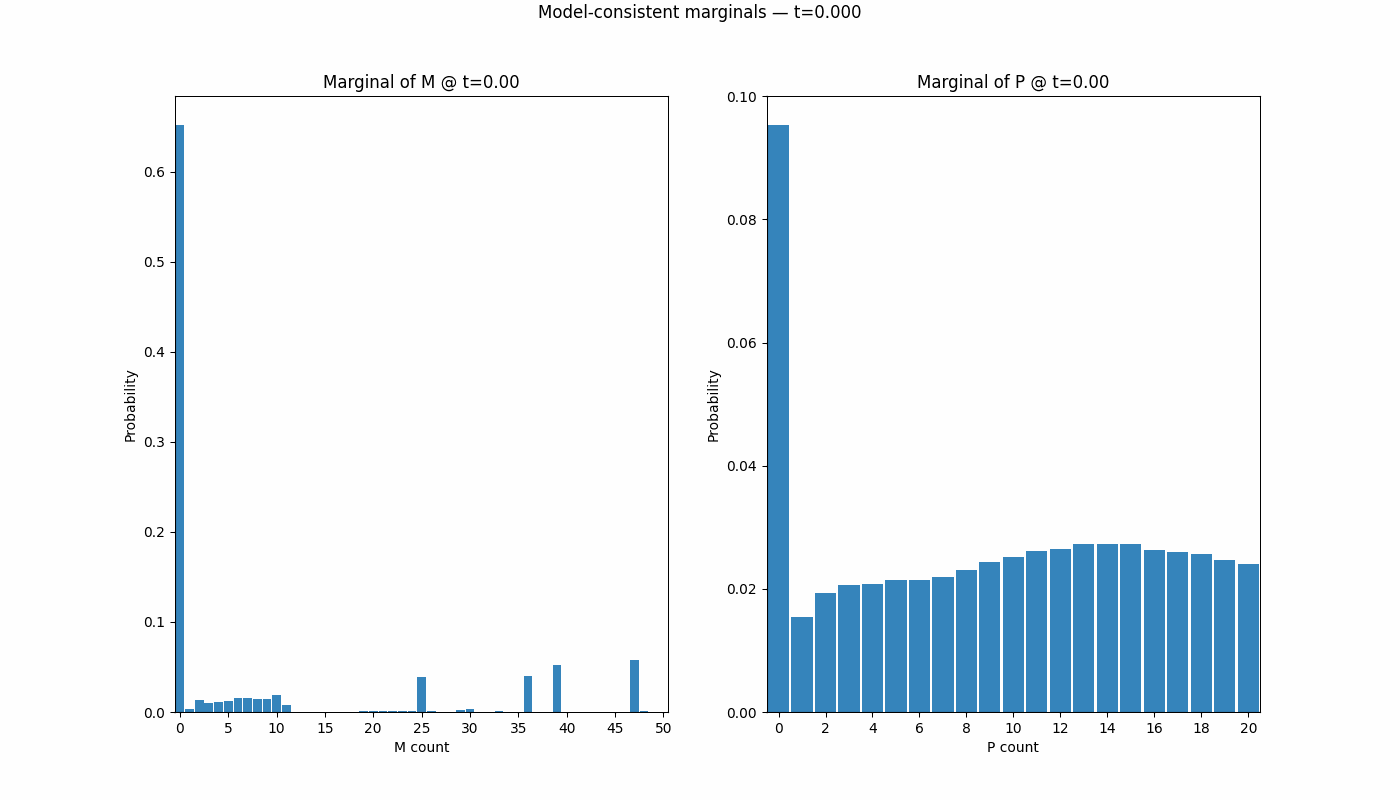

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as iio  # pip install imageio

def animate_marginals(
    crn, net,
    t_fin, dt,
    K_per_species=50000,
    chunk_size=4096,
    cols=3, figsize=(14, 8),
    title="Model-consistent marginals",
    gif_path="marginals.gif",
    fps=None,
    verbose=True,
):
    """
    Renders plot_marginals_model at times 0..t_fin (step dt) and saves an animated GIF.
    Works even if plot_marginals_model creates its own figure internally.
    """
    # Build the time grid (inclusive of t_fin, accounting for float rounding)
    ts = np.arange(0.0, t_fin + 1e-12, dt)

    frames = []
    for t in ts:
        # Re-render the plot for this time
        fig, _ = plot_marginals_model(
            crn, net, t=float(t),
            K_per_species=K_per_species,
            chunk_size=chunk_size,
            cols=cols, figsize=figsize,
            title=f"{title} — t={t:.3f}"
        )
        fig.tight_layout()

        # Draw and grab RGBA buffer
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        # buffer_rgba() is backend-agnostic and already RGBA
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        buf = buf.reshape((h, w, 4))
        frames.append(buf)

        plt.close(fig)
        if verbose:
            print(f"Rendered frame at t={t:.3f}")

    # Choose FPS if not provided (rough heuristic)
    if fps is None:
        fps = max(1, int(round(1.0 / dt))) if dt > 0 else 5

    # Save GIF (loop=0 means loop forever)
    iio.mimsave(gif_path, frames, duration=1.0 / fps, loop=0)
    if verbose:
        print(f"Saved animation to {gif_path} ({len(frames)} frames @ {fps} fps)")

    return gif_path

# --- Usage example ---
gif_path = animate_marginals(crn, net, t_fin=1.5, dt=0.05, verbose=True)
from IPython.display import Image; Image(filename=gif_path)

NameError: name 'sample_marginal' is not defined

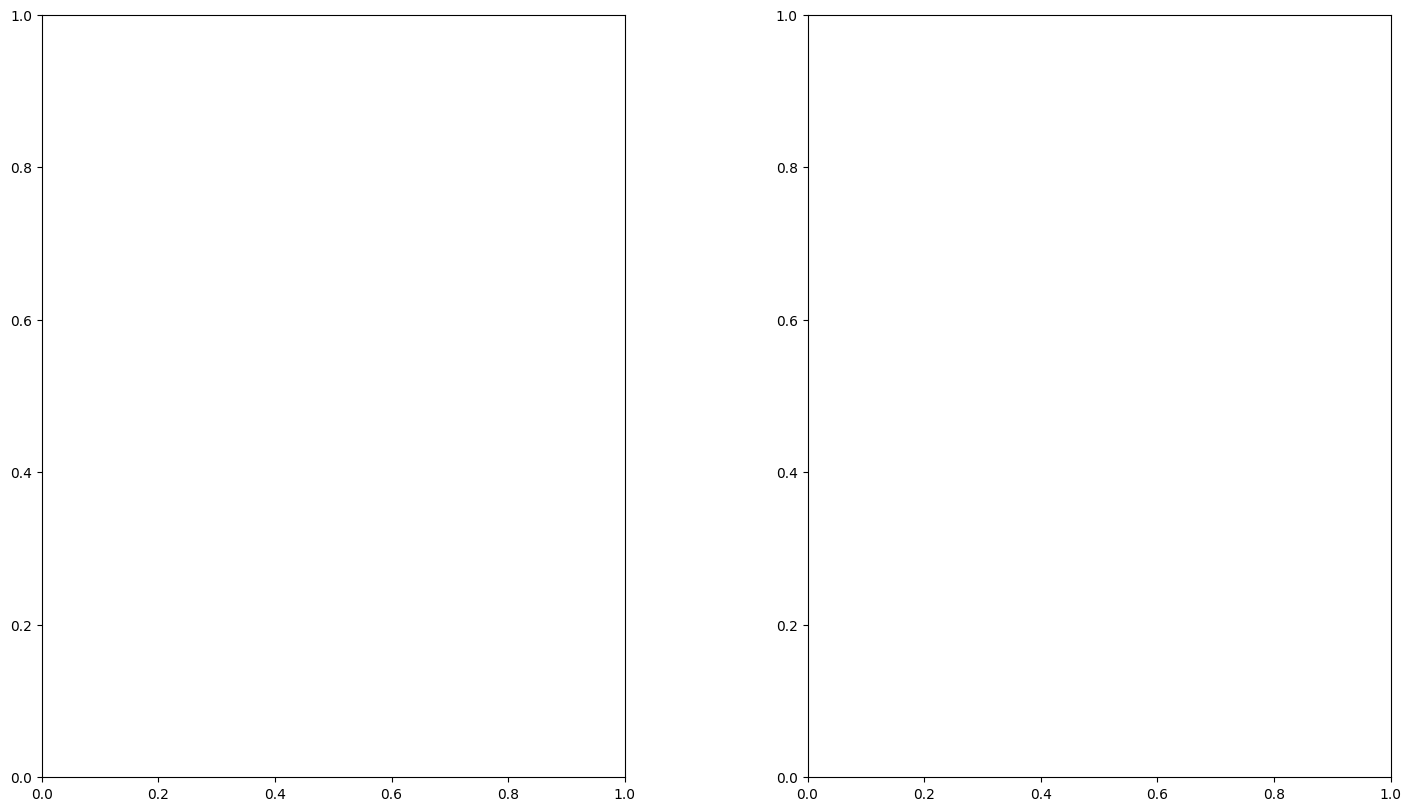

In [ ]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_marginals_model(
    crn, net, t,
    K_per_species=20_000,     # total MC budget per species
    chunk_size=2_048,         # streamed eval size (controls VRAM)
    cols=3, figsize=(14, 8),
    title=None
):
    """
    Plot model-consistent marginals p_theta(x_s | t) for each species,
    computed by averaging the target head's conditional over samples of
    *preceding* species only (ancestral in the AR order).

    We accumulate a running average over multiple calls to
    net.sample_marginal(t, target=..., K=chunk_K) to limit VRAM usage.

    Args:
        crn: object with .species and .species_marginals_sizes
        net: model exposing net.sample_marginal(t, target, K)
        t:   scalar time (float or 0-dim tensor)
        K_per_species: total number of MC samples used per species
        chunk_size: batch size per streamed call
        cols: subplots per full row
        figsize: matplotlib figure size
        title: optional suptitle
    """
    device = getattr(net, "device", getattr(crn, "DEVICE", "cpu"))
    species_list = list(crn.species)
    S = len(species_list)

    # --- layout: last row expands to its #panels
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    full_rows = S // cols
    rem = S % cols
    nrows = full_rows + (1 if rem else 0)
    outer = fig.add_gridspec(nrows, 1, hspace=0.35)

    axes_rows = []
    sp_idx = 0
    for r in range(nrows):
        ncols_r = cols if (r < full_rows or rem == 0) else rem
        inner = outer[r].subgridspec(1, ncols_r, wspace=0.20)
        row_axes = [fig.add_subplot(inner[0, c]) for c in range(ncols_r)]
        axes_rows.append(row_axes)

    # --- helper: streamed average
    def streamed_marginal(target_name, total_K, chunk):
        C = int(crn.species_marginals_sizes[target_name])
        acc = torch.zeros(C, dtype=torch.float64)  # CPU accumulator
        remaining = int(total_K)
        while remaining > 0:
            thisK = min(int(chunk), remaining)
            # net.sample_marginal returns [C] on the model device
            m = sample_marginal(net, t=t, target=target_name, K=thisK)  # [C]
            acc += (thisK * m.detach().to("cpu", dtype=torch.float64))
            remaining -= thisK
        return (acc / float(total_K)).to(dtype=torch.float32).numpy()

    # --- plot each species
    sp_idx = 0
    for r, row_axes in enumerate(axes_rows):
        for ax in row_axes:
            if sp_idx >= S:
                ax.axis("off")
                continue

            s_name = species_list[sp_idx]
            C_s = int(crn.species_marginals_sizes[s_name])

            # estimate marginal in a VRAM-friendly way
            probs = streamed_marginal(s_name, K_per_species, chunk_size)  # [C_s], sums to 1

            # draw
            x = np.arange(C_s)
            ax.bar(x, probs, alpha=0.9, width=0.9)
            t_scalar = float(t.item()) if torch.is_tensor(t) else float(t)
            ax.set_title(f"Marginal of {s_name} @ t={t_scalar:.2f}")
            ax.set_xlabel(f"{s_name} count")
            ax.set_ylabel("Probability")
            
            
            if C_s <= 20:
                ax.set_xticks(x)
            else:
                step = max(1, C_s // 10)
                ax.set_xticks(np.arange(0, C_s, step))

            sp_idx += 1

    if title:
        fig.suptitle(title, y=0.995)
    return fig, axes_rows


fig, _ = plot_marginals_model(
    crn, net, t=1.,
    K_per_species=50_000,   # total MC draws per species
    chunk_size=2048,        # fits your GPU
    cols=3, figsize=(14, 8),
    title="Model-consistent marginals"
)
plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plot_marginals(crn, net, t=0., n_samples=10000)
# fig.savefig("marginals_t0p5.png", dpi=150, bbox_inches="tight")
# plt.show()

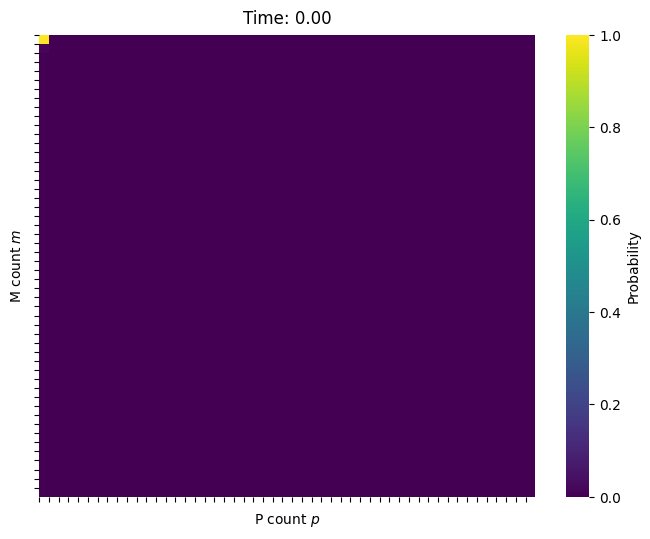

In [65]:
# Grid evaluation + plotting (2-species, CRN-aware)
# -------------------------------------------------
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _onehot(idx, n):
    return F.one_hot(idx.clamp(0, n - 1).long(), n).float()

def _infer_device(net):
    try:
        return next(net.parameters()).device
    except StopIteration:
        return torch.device("cpu")

def _eval_probs_api(net, oh_m, oh_p, t_vec):
    """
    Works with either:
      net.get_probability(oh_m, oh_p, oh_m_soft, t)
    or
      net.get_probability(oh_m, oh_p, t)
    """
    try:
        return net.get_probability([oh_m, oh_p], t_vec)
    except TypeError:
        return net.get_probability([oh_m, oh_p], t_vec)

@torch.no_grad()
def eval_grid_probs(net, crn, t_scalar, *, m_max=None, p_max=None, device=None, batch_size=None):
    """
    Evaluate p(m,p | t_scalar) over the full lattice.
      - crn: object providing M_MAX, P_MAX
      - m_max/p_max: optional overrides; defaults to crn.M_MAX/crn.P_MAX
    Returns numpy array of shape [m_max+1, p_max+1].
    """
    if device is None:
        device = _infer_device(net)

    # bounds
    mm = int(crn.M_MAX if m_max is None else m_max)
    pp = int(crn.P_MAX if p_max is None else p_max)

    t_scalar = float(t_scalar)
    m_all = torch.arange(mm + 1, device=device)
    p_all = torch.arange(pp + 1, device=device)
    M, P = torch.meshgrid(m_all, p_all, indexing="ij")
    m_flat, p_flat = M.flatten(), P.flatten()
    N = m_flat.numel()

    probs = torch.empty(N, device=device)

    if batch_size is None or batch_size >= N:
        oh_m = _onehot(m_flat, mm + 1)
        oh_p = _onehot(p_flat, pp + 1)
        t_vec = torch.full((N,), t_scalar, device=device)
        probs[:] = _eval_probs_api(net, oh_m, oh_p, t_vec).clamp_min(0)
    else:
        bs = int(batch_size)
        for s in range(0, N, bs):
            e = min(s + bs, N)
            oh_m = _onehot(m_flat[s:e], mm + 1)
            oh_p = _onehot(p_flat[s:e], pp + 1)
            t_vec = torch.full((e - s,), t_scalar, device=device)
            probs[s:e] = _eval_probs_api(net, oh_m, oh_p, t_vec).clamp_min(0)

    return probs.view(mm + 1, pp + 1).detach().cpu().numpy()

@torch.no_grad()
def plot_heatmap(
    net, crn, t, *,
    m_max=None, p_max=None, device=None, batch_size=None,
    ax=None, hm=None, title=None, normalize="max",
    x_label=None, y_label=None
):
    """
    Create or update a heatmap of p(m,p | t), CRN-aware (no globals).
      - labels default to CRN species if available (e.g., 'P', 'M').
    """
    if isinstance(t, torch.Tensor):
        if t.numel() != 1:
            raise ValueError("t must be scalar.")
        t = float(t.item())

    # dimension defaults from CRN
    mm = int(crn.M_MAX if m_max is None else m_max)
    pp = int(crn.P_MAX if p_max is None else p_max)

    # default axis labels from CRN species (if present)
    sp = getattr(crn, "species", ["m", "p"])
    if len(sp) < 2:
        sp = ["m", "p"]
    _x_label = x_label if x_label is not None else f"{sp[1]} count $p$"
    _y_label = y_label if y_label is not None else f"{sp[0]} count $m$"

    grid = eval_grid_probs(net, crn, t, m_max=mm, p_max=pp, device=device, batch_size=batch_size)

    # Optional normalization for visualization
    if normalize == "max":
        m = grid.max();  grid = grid / m if m > 0 else grid
        vmin, vmax = 0.0, 1.0
    elif normalize == "sum":
        s = grid.sum();  grid = grid / s if s > 0 else grid
        vmin, vmax = 0.0, 1.0
    else:
        vmin = vmax = None

    import seaborn as sns
    if hm is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        hm = sns.heatmap(
            grid, cmap="viridis", vmin=vmin, vmax=vmax,
            cbar_kws={'label': 'Probability'}, ax=ax, annot=False
        )
        ax.set_xlabel(_x_label)
        ax.set_ylabel(_y_label)
        ax.set_xticks(np.arange(pp + 1))
        ax.set_yticks(np.arange(mm + 1))
    else:
        # update in place
        hm.collections[0].set_array(grid.ravel())
        if vmin is not None and vmax is not None:
            hm.collections[0].set_clim(vmin, vmax)
        hm.figure.canvas.draw_idle()

    if title is not None:
        ax.set_title(title, pad=8)
    return ax, hm

def animate_heatmap(
    net, crn, *, t_max, m_max=None, p_max=None, num_frames=50, fps=10,
    device=None, batch_size=None, normalize="max",
    x_label=None, y_label=None
):
    # first frame
    ax, hm = plot_heatmap(
        net, crn, 0.0,
        m_max=m_max, p_max=p_max, device=device, batch_size=batch_size,
        title="Time: 0.00", normalize=normalize, ax=None, hm=None,
        x_label=x_label, y_label=y_label
    )

    def update(frame):
        t_val = frame * t_max / max(1, (num_frames - 1))
        plot_heatmap(
            net, crn, t_val,
            m_max=m_max, p_max=p_max, device=device, batch_size=batch_size,
            ax=ax, hm=hm, title=f"Time: {t_val:.2f}", normalize=normalize,
            x_label=x_label, y_label=y_label
        )
        return hm.collections

    ani = animation.FuncAnimation(
        hm.figure, update,
        frames=num_frames, blit=False, repeat=True, interval=1000//fps
    )
    return ani

# Example usage (no globals):
ani = animate_heatmap(
    net, crn,
    t_max=TF, num_frames=50, fps=10,
    normalize="max",          # or "max" or None
    batch_size=4096           # optional; helps on large grids
)
ani.save("gene_expression_softmax.gif", writer="pillow", fps=10)


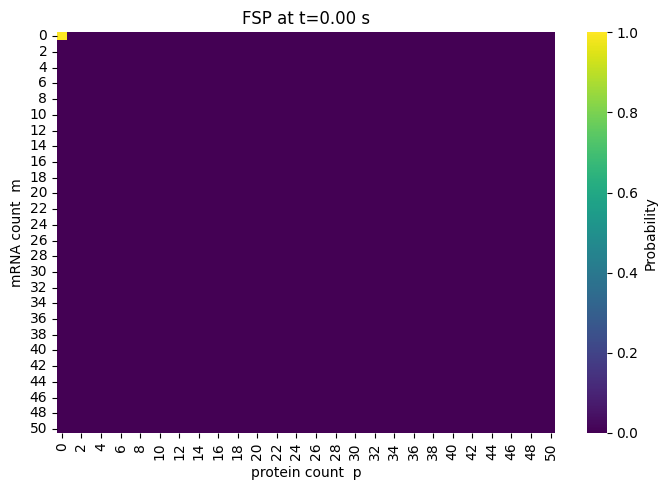

animation saved ➜ gene_expression_fsp.gif


In [56]:
# ====== FSP using CRN.apply_A ======
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

M_MAX, P_MAX = crn.M_MAX, crn.P_MAX  # Global dimensions
# 1) Dimensions (keep your globals)
N = (M_MAX + 1) * (P_MAX + 1)

# 2) ODE RHS calls the CRN
def fsp_ode(t, y, crn, M_MAX, P_MAX):
    return crn.apply_A(y, M_MAX, P_MAX)

# 3) Solve
def solve_fsp(crn, t_span=(0, 10), y0=None, steps=100, m0=0, p0=0):
    if y0 is None:
        y0 = np.zeros(N)
        idx0 = m0 * (P_MAX + 1) + p0
        y0[idx0] = 1.0

    t_eval = np.linspace(t_span[0], t_span[1], steps)
    sol = solve_ivp(
        fsp_ode, t_span, y0,
        args=(crn, M_MAX, P_MAX),
        t_eval=t_eval, rtol=1e-6, atol=1e-9
    )
    return sol.t, sol.y  # y shape (N, len(t_eval))

# 4) Plot helpers unchanged
def plot_fsp_heat(y_flat, *, ax=None, annotate=True, title=None, normalize=None):
    grid = y_flat.reshape(M_MAX + 1, P_MAX + 1)

    if normalize == "max":
        m = grid.max()
        if m > 0: grid = grid / m
    elif normalize == "sum":
        s = grid.sum()
        if s > 0: grid = grid / s

    own_fig = ax is None
    if own_fig:
        fig, ax = plt.subplots(figsize=(7, 5))

    im = sns.heatmap(grid, ax=ax, cmap="viridis", cbar_kws={'label': 'Probability'}, annot=False)

    txts = []
    if annotate:
        for (i, j), val in np.ndenumerate(grid):
            txts.append(ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                                ha='center', va='center', color='black', fontsize=7))

    ax.set_xlabel("protein count  p")
    ax.set_ylabel("mRNA count  m")
    if title:
        ax.set_title(title)

    if own_fig:
        plt.tight_layout(); plt.show()

    return ax, im, txts

import matplotlib.animation as animation

def animate_fsp(t, y, *, annotate=False, fps=10, outfile="fsp_evolution.gif", normalize="max"):
    ax, im, txts = plot_fsp_heat(
        y[:, 0], annotate=annotate, normalize=normalize, title=f"FSP at t={t[0]:.2f} s"
    )

    def update(frame):
        grid = y[:, frame].reshape(M_MAX + 1, P_MAX + 1)
        if normalize == "max":
            m = grid.max();  grid = grid / m if m > 0 else grid
        elif normalize == "sum":
            s = grid.sum();  grid = grid / s if s > 0 else grid

        im.collections[0].set_array(grid.ravel())
        if annotate:
            for txt, val in zip(txts, grid.ravel()):
                txt.set_text(f"{val:.2f}")
        ax.set_title(f"FSP at t={t[frame]:.2f} s")
        return im.collections + txts

    ani = animation.FuncAnimation(im.figure, update, frames=len(t), blit=False, repeat=True)
    ani.save(outfile, writer='pillow', fps=fps)
    print(f"animation saved ➜ {outfile}")
    return ani

t, y = solve_fsp(crn, t_span=(0, TF), steps=50)   # y shape (N, T)
animate_fsp(t, y, annotate=False, fps=10, outfile="gene_expression_fsp.gif")


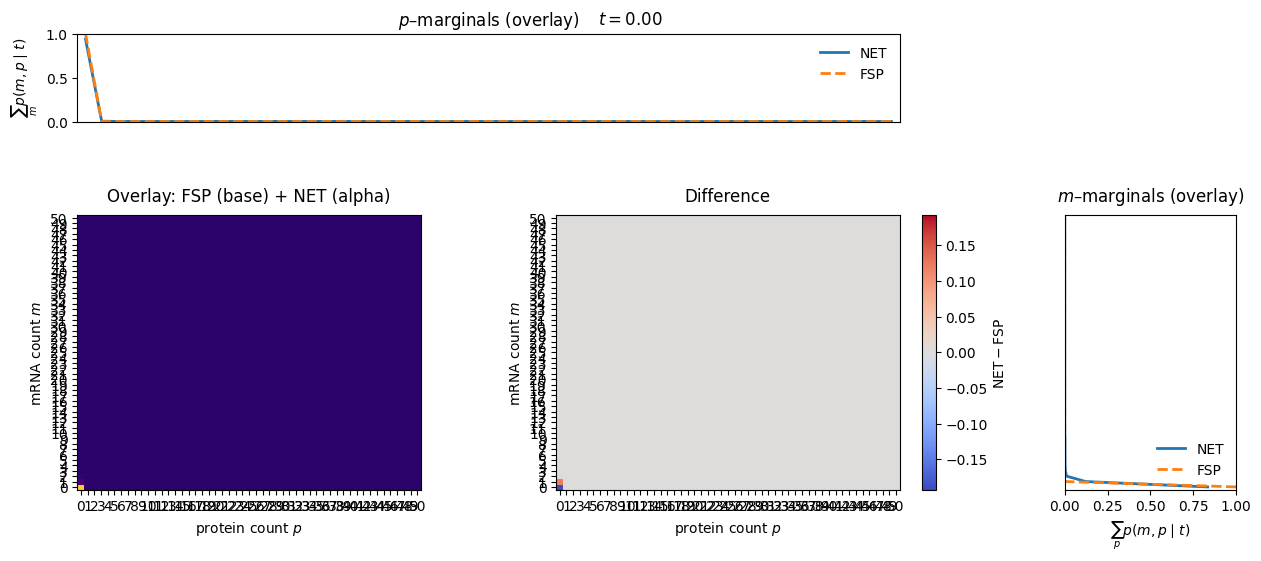

In [57]:
# Overlay (NET vs FSP) w/ LaTeX labels — parametric M_MAX/P_MAX/device
# ===============================
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _infer_device(net):
    try:
        return next(net.parameters()).device
    except StopIteration:
        return torch.device("cpu")

def _eval_probs_api(net, oh_m, oh_p, t_vec):
    """
    New API: get_probability(hard_ohs, soft_ohs, t)
    Legacy fallback: get_probability(oh_m, oh_p, t)
    """
    hard = [oh_m, oh_p]  # [B, 2, C]
    return net.get_probability(hard, t_vec)


def _net_grid_at_time(net, t_scalar, M_MAX, P_MAX, device):
    m_all = torch.arange(M_MAX + 1, device=device)
    p_all = torch.arange(P_MAX + 1, device=device)
    M, P = torch.meshgrid(m_all, p_all, indexing="ij")
    oh_m = F.one_hot(M.flatten(), M_MAX + 1).to(dtype=torch.float32, device=device)
    oh_p = F.one_hot(P.flatten(), P_MAX + 1).to(dtype=torch.float32, device=device)
    t_vec = torch.full((oh_m.shape[0],), float(t_scalar), device=device)
    with torch.no_grad():
        probs = _eval_probs_api(net, oh_m, oh_p, t_vec).clamp_min(0)
    return probs.view(M_MAX + 1, P_MAX + 1).detach().cpu().numpy()

def _fsp_vec_at_time(t_scalar, t_grid, y_matrix):
    if t_scalar <= t_grid[0]:   return y_matrix[:, 0]
    if t_scalar >= t_grid[-1]:  return y_matrix[:, -1]
    i1 = np.searchsorted(t_grid, t_scalar); i0 = i1 - 1
    t0, t1 = t_grid[i0], t_grid[i1]
    w = (t_scalar - t0) / (t1 - t0 + 1e-12)
    return (1.0 - w) * y_matrix[:, i0] + w * y_matrix[:, i1]

def _grid_from_vec(y_vec, M_MAX, P_MAX):
    return y_vec.reshape(M_MAX + 1, P_MAX + 1)

def animate_overlay_and_diff(
    net, fsp_t, fsp_y, *,
    M_MAX, P_MAX,
    t_max,
    device=None,
    num_frames=50,
    normalize="sum",
    fps=10,
    diff_abs=False,
    overlay_alpha=0.45,
    use_tex=False
):
    if use_tex:
        from matplotlib import rcParams
        rcParams["text.usetex"] = True
        rcParams["font.family"] = "serif"

    if device is None:
        device = _infer_device(net)

    def _normalize(grid):
        if normalize == "sum":
            s = grid.sum();  return grid / s if s > 0 else grid
        if normalize == "max":
            m = grid.max();  return grid / m if m > 0 else grid
        return grid

    fig = plt.figure(constrained_layout=True, figsize=(12.5, 5.5))
    gs = fig.add_gridspec(
        2, 3,
        width_ratios=[2.0, 2.0, 1.0],
        height_ratios=[0.32, 1.0],
        wspace=0.10, hspace=0.20
    )
    ax_top     = fig.add_subplot(gs[0, :2])  # overlaid p-marginals
    ax_overlay = fig.add_subplot(gs[1, 0])   # overlay: FSP base + NET alpha heatmap
    ax_diff    = fig.add_subplot(gs[1, 1])   # difference heatmap
    ax_right   = fig.add_subplot(gs[1, 2])   # overlaid m-marginals

    t0 = 0.0
    grid_net = _normalize(_net_grid_at_time(net, t0, M_MAX, P_MAX, device))
    grid_fsp = _normalize(_grid_from_vec(_fsp_vec_at_time(t0, fsp_t, fsp_y), M_MAX, P_MAX))

    vmin = 0.0 if normalize in ("sum", "max") else None
    vmax = 1.0 if normalize in ("sum", "max") else None

    im_base = ax_overlay.imshow(
        grid_fsp, origin="lower", aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax
    )
    im_overlay = ax_overlay.imshow(
        grid_net, origin="lower", aspect="auto", cmap="plasma", vmin=vmin, vmax=vmax, alpha=overlay_alpha
    )
    ax_overlay.set_title(r"Overlay: FSP (base) + NET (alpha)", pad=10)
    ax_overlay.set_xlabel(r"protein count $p$")
    ax_overlay.set_ylabel(r"mRNA count $m$")
    ax_overlay.set_xticks(np.arange(P_MAX + 1)); ax_overlay.set_yticks(np.arange(M_MAX + 1))

    diff0 = (np.abs(grid_net - grid_fsp)/(grid_fsp + 1e6) if diff_abs else (grid_net - grid_fsp))
    dv = (np.max(np.abs(diff0)) or 1e-6) if not diff_abs else (np.max(diff0) or 1e-6)
    if diff_abs:
        im_diff = ax_diff.imshow(diff0, origin="lower", aspect="auto", cmap="magma", vmin=0.0, vmax=dv)
        cbar = fig.colorbar(im_diff, ax=ax_diff, fraction=0.046, pad=0.05)
        cbar.set_label(r"$\lvert\,\text{NET}-\text{FSP}\,\rvert$")
    else:
        im_diff = ax_diff.imshow(diff0, origin="lower", aspect="auto", cmap="coolwarm", vmin=-dv, vmax=dv)
        cbar = fig.colorbar(im_diff, ax=ax_diff, fraction=0.046, pad=0.05)
        cbar.set_label(r"$\text{NET}-\text{FSP}$")
    ax_diff.set_title(r"Difference", pad=10)
    ax_diff.set_xlabel(r"protein count $p$")
    ax_diff.set_ylabel(r"mRNA count $m$")
    ax_diff.set_xticks(np.arange(P_MAX + 1)); ax_diff.set_yticks(np.arange(M_MAX + 1))

    # p–marginals (top): sum over m
    p_net, p_fsp = grid_net.sum(0), grid_fsp.sum(0)
    ln_p_net, = ax_top.plot(np.arange(P_MAX + 1), p_net, label=r"NET", lw=2)
    ln_p_fsp, = ax_top.plot(np.arange(P_MAX + 1), p_fsp, label=r"FSP", lw=2, linestyle="--")
    ax_top.set_xlim(-0.5, P_MAX + 0.5); ax_top.set_xticks([])
    ax_top.set_ylabel(r"$\sum_{m} p(m,p\mid t)$")
    if normalize in ("sum", "max"): ax_top.set_ylim(0, 1.0)
    ax_top.legend(loc="upper right", frameon=False)
    ax_top.set_title(r"$p$–marginals (overlay)", pad=6)

    # m–marginals (right): sum over p
    m_net, m_fsp = grid_net.sum(1), grid_fsp.sum(1)
    ln_m_net, = ax_right.plot(m_net, np.arange(M_MAX + 1), label=r"NET", lw=2)
    ln_m_fsp, = ax_right.plot(m_fsp, np.arange(M_MAX + 1), label=r"FSP", lw=2, linestyle="--")
    ax_right.set_ylim(-0.5, M_MAX + 0.5); ax_right.set_yticks([])
    ax_right.set_xlabel(r"$\sum_{p} p(m,p\mid t)$")
    if normalize in ("sum", "max"): ax_right.set_xlim(0, 1.0)
    ax_right.legend(loc="lower right", frameon=False)
    ax_right.set_title(r"$m$–marginals (overlay)", pad=10)

    suptitle = fig.suptitle(rf"$t = {t0:.2f}$", y=0.99)

    def update(frame):
        t_val = frame * t_max / max(1, (num_frames - 1))
        gn = _normalize(_net_grid_at_time(net, t_val, M_MAX, P_MAX, device))
        gf = _normalize(_grid_from_vec(_fsp_vec_at_time(t_val, fsp_t, fsp_y), M_MAX, P_MAX))

        im_base.set_data(gf)
        im_overlay.set_data(gn)

        d = (np.abs(gn - gf) if diff_abs else (gn - gf))
        im_diff.set_data(d)

        ln_p_net.set_ydata(gn.sum(0)); ln_p_fsp.set_ydata(gf.sum(0))
        ln_m_net.set_xdata(gn.sum(1));  ln_m_fsp.set_xdata(gf.sum(1))

        suptitle.set_text(rf"$t = {t_val:.2f}$")
        return (im_base, im_overlay, im_diff, ln_p_net, ln_p_fsp, ln_m_net, ln_m_fsp, suptitle)

    ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False, interval=1000//fps)
    return ani


# -------- Example usage (make sure you pass the right FSP tensors) --------
# Suppose you have:
#   t_fsp, y_fsp = solve_fsp(crn, t_span=(0, 1.5), steps=50)  # y_fsp shape: (N_STATES, T)
# and your lattice limits:
#   M_MAX, P_MAX = crn.M_MAX, crn.P_MAX

device = next(net.parameters()).device
ani = animate_overlay_and_diff(
    net, t, y,
    M_MAX=M_MAX, P_MAX=P_MAX, device=device,
    t_max=TF, num_frames=50, normalize="sum", fps=10, diff_abs=False
)
ani.save("overlay_diff_marginals.gif", writer="pillow", fps=10)


In [ ]:
# plot marginals (MC approach) 

# import matplotlib.pyplot as plt

# def plot_marginals(crn, net, t, n_samples= 10000):

#     t = torch.full((n_samples,), t, device=DEVICE)  # [N]
#     for s in crn.species:
#         probs = []
#         for c in range(crn.species_marginals_sizes[s]):
#             # randomly sample the other species 
#             queue = []
#             for s2 in crn.species:
#                 if s2 != s:
#                     queue.append(torch.randint(0, crn.species_marginals_sizes[s2], (n_samples,)).to(DEVICE))
#                 else:
#                     queue.append(torch.ones(n_samples, dtype=torch.int64, device=DEVICE) * c)
            
            
#             probs.append(net.prob_mp(t, torch.stack(queue, dim=1)))

#         # plot the marginal distribution
#         plt.bar(range(crn.species_marginals_sizes[s]), torch.stack(probs, dim=1).mean(dim=0).detach().cpu().numpy(), alpha=0.5, label=s)
#         plt.xlabel("Probability")
#         plt.ylabel("Density")
#         plt.title("Marginal distributions")
#         plt.legend()
#         plt.show()


# plot_marginals(crn, net, t=0.5, n_samples=10000)

# [This monte carlo marginal approach can work only for small systems, where the number of states is not too large. For larger systems, we need to use a different approach, such as importance sampling or MCMC methods.]

# import math
# import torch
# import numpy as np
# import matplotlib.pyplot as plt

# def _marginal_probs_chunked(net, t_vec, species_mat, *, C_s, n_samples, chunk_size=None):
#     """
#     Compute the marginal probs for a single species by streaming in chunks.

#     Args:
#         net:          model with prob_mp
#         t_vec:        [C_s*n_samples]
#         species_mat:  [C_s*n_samples, S] integer states
#         C_s:          number of bins for the target species
#         n_samples:    MC samples per bin
#         chunk_size:   max batch size processed on GPU (e.g., 65536). If None, do it in one go.

#     Returns:
#         probs: numpy array of shape [C_s]
#     """
#     N = species_mat.size(0)
#     device = t_vec.device

#     if chunk_size is None or chunk_size >= N:
#         with torch.no_grad():
#             probs = net.prob_mp(t_vec, species_mat).clamp_min(0.0)
#         return probs.view(C_s, n_samples).mean(dim=1).detach().cpu().numpy()

#     # Accumulate sums per bin on CPU to keep GPU use low
#     sums_cpu = torch.zeros(C_s, dtype=torch.float64)

#     with torch.no_grad():
#         for s in range(0, N, int(chunk_size)):
#             e = min(s + int(chunk_size), N)

#             # Evaluate this chunk on GPU
#             p_chunk = net.prob_mp(t_vec[s:e], species_mat[s:e]).clamp_min(0.0)  # [L]

#             # Map each row index -> target-bin index in [0..C_s-1]
#             # Because states were built as blocks of size n_samples per bin.
#             bins = (torch.arange(s, e, device=device, dtype=torch.long) // n_samples)  # [L]

#             # Reduce on GPU, then move a tiny [C_s] vector to CPU
#             accum = torch.zeros(C_s, device=device, dtype=p_chunk.dtype)
#             accum.scatter_add_(0, bins, p_chunk)
#             sums_cpu += accum.double().cpu()

#     # Average over the n_samples for each bin
#     probs = (sums_cpu / float(n_samples)).to(dtype=torch.float32).numpy()
#     return probs

# # size of the space of "other species"
# def _other_space_size(crn, target_name):
#     size = 1
#     for sp in crn.species:
#         if sp != target_name:
#             size *= int(crn.species_marginals_sizes[sp])
#     return size


# def plot_marginals(crn, net, t, n_samples=10_000, cols=3, figsize=(14, 8)):
#     """
#     Monte-Carlo marginals for each species at time t.
#     Layout: full rows of `cols`, and the last row (if partial) expands to fill width.

#     Args:
#         crn: object with .species and .species_marginals_sizes
#         net: model exposing net.prob_mp(t_vec[B], species_vec[B,S])
#         t:   scalar time (float or 0-dim tensor)
#         n_samples: MC samples per value of the target species
#         cols: plots per full row
#         figsize: figure size
#     """
#     # device
#     device = getattr(net, "device", getattr(crn, "DEVICE", "cpu"))
#     device = torch.device(device)

#     # time scalar
#     t_scalar = float(t.item()) if isinstance(t, torch.Tensor) else float(t)

#     species_list = list(crn.species)
#     S = len(species_list)
#     if S == 0:
#         raise ValueError("crn.species is empty.")

#     # figure + outer GridSpec (one column; each row will get its own inner GridSpec with a custom ncols)
#     fig = plt.figure(figsize=figsize, constrained_layout=True)
#     full_rows = S // cols
#     rem = S % cols
#     nrows = full_rows + (1 if rem else 0)
#     outer = fig.add_gridspec(nrows, 1, hspace=0.35)

#     # build axes: full rows with `cols`, last row with `rem` (or `cols` if rem==0)
#     axes_rows = []
#     sp_idx = 0
#     for r in range(nrows):
#         ncols_r = cols if (r < full_rows or rem == 0) else rem
#         inner = outer[r].subgridspec(1, ncols_r, wspace=0.10)
#         row_axes = []
#         for c in range(ncols_r):
#             ax = fig.add_subplot(inner[0, c])
#             row_axes.append(ax)
#             sp_idx += 1
#         axes_rows.append(row_axes)

#     # plotting
#     sp_idx = 0
#     for r, row_axes in enumerate(axes_rows):
#         for c, ax in enumerate(row_axes):
#             if sp_idx >= S:
#                 ax.axis("off")
#                 continue

#             s_idx = sp_idx
#             s_name = species_list[s_idx]
#             C_s = int(crn.species_marginals_sizes[s_name])

#             # Base random draw for all species (uniform supports) [n_samples, S]
#             all_rand = []
#             for sp in species_list:
#                 C = int(crn.species_marginals_sizes[sp])
#                 all_rand.append(torch.randint(0, C, (n_samples,), device=device, dtype=torch.long))
#             base = torch.stack(all_rand, dim=1)  # [n_samples, S]

#             # Repeat base for each value of the target species
#             species_mat = base.repeat_interleave(C_s, dim=0)  # [n_samples*C_s, S]

#             # Overwrite target column with every 0..C_s-1 (each repeated n_samples times)
#             vals_s = torch.arange(C_s, device=device, dtype=torch.long).repeat_interleave(n_samples)
#             species_mat[:, s_idx] = vals_s

#             # Time vector
#             t_vec = torch.full((species_mat.size(0),), t_scalar, device=device)

#             # Evaluate probabilities and average across samples for each bin
#             probs = _marginal_probs_chunked(
#                 net, t_vec, species_mat,
#                 C_s=C_s, n_samples=n_samples,
#                 chunk_size=65536   # <- tune this to your GPU
#             )

#             # unbiased IS correction for uniform q(x_-s)
#             D_other = _other_space_size(crn, s_name)
#             probs = probs * float(D_other)

#             # (optional) ensure numerical cleanliness
#             probs = np.clip(probs, 0.0, None)
#             s = probs.sum()
#             if s > 0:
#                 probs = probs / s

#             # plot
#             ax.bar(np.arange(C_s), probs, alpha=0.85, width=0.9)
#             ax.set_title(f"Marginal of {s_name} @ t={t_scalar:.2f}")
#             ax.set_xlabel(f"{s_name} count")
#             ax.set_ylabel("Probability")
#             ax.set_xlim(-0.5, C_s - 0.5)
#             if C_s <= 20:
#                 ax.set_xticks(np.arange(C_s))
#             else:
#                 step = max(1, C_s // 10)
#                 ax.set_xticks(np.arange(0, C_s, step))

#             sp_idx += 1

#     return fig, axes_rows


